<a href="https://colab.research.google.com/github/msiddalingaiah/MachineLearning/blob/master/Recommendations/Item_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Item Similarity

[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) can do more than make recommendations. A by-product of training a collaborative filtering recommendation model is to discover item similarity. In this case, it means finding movies that are similar based on user ratings. In the same way, it is possible to find similar users.

In [1]:
%tensorflow_version 2.x

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from tqdm import tqdm

# Load data

In this example, we will make movie recommendations given about 100,000 samples from roughly 10,000 customers or users.

The data set is freely available on the [MovieLens website](https://grouplens.org/datasets/movielens/).

In [3]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2020-09-24 14:27:04--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.36MB/s    in 0.3s    

2020-09-24 14:27:05 (3.36 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [4]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [5]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Join Ratings with Movies

The ratings don't contain movie titles, so let's join or merge these two sets for convenience.

In [7]:
ratings = ratings.merge(movies, on='movieId').drop(['genres','timestamp'],axis=1)
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


## Generate Sequential Identifiers

`userId` and `movieId` are not sequential, which causes problems for our model. To compensate, we can use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) class from [scikit-learn](https://scikit-learn.org/) to generate sequential identifiers for users and movies. The original identifiers are still available, so we can always join back to the original data set if needed.

In [8]:
user_enc = LabelEncoder()
ratings['userSeq'] = user_enc.fit_transform(ratings['userId'].values)

item_enc = LabelEncoder()
ratings['movieSeq'] = item_enc.fit_transform(ratings['movieId'].values)

ratings.head()

,userId,movieId,rating,title,userSeq,movieSeq
0,1,1,4.0,Toy Story (1995),0,0
1,5,1,4.0,Toy Story (1995),4,0
2,7,1,4.5,Toy Story (1995),6,0
3,15,1,2.5,Toy Story (1995),14,0
4,17,1,4.5,Toy Story (1995),16,0


## Train/Test Split

This case is a bit unusual because we need ratings for every movie from every user to train an accurate model. If we used a traditional split, some movies might be left out, which will cause problems during prediction.

For this reason, we will use all of the data for training and a subset for model validation only.

In [9]:
train_unused, test = train_test_split(ratings, test_size=0.20, random_state=0)

# All data is used for training
train = ratings

numUsers = len(train.userSeq.unique())
numMovies = len(train.movieSeq.unique())
print((numUsers, numMovies))
print((len(train), len(test)))

(610, 9724)
(100836, 20168)


## Recommendation Model

Collaborative filtering tries to minimize the error between a predicted value and ground truth. This is similar to many supervised machine learning problems. The model learns a set of features that similar movies share. The number of features could be as simple as the genre or more complex. The `numFeatures` variable below is a hyperparameter that can be tuned to optimize performance.

This model uses the [Keras functional API](https://keras.io/getting-started/functional-api-guide/) rather than adding layers to a Sequential model. This is necessary because we have two sets of inputs, userSeq and movieSeq.

In [17]:
numFeatures = 50
dropout = 0.0

user_input = Input(shape=(1,))
user_emb = Embedding(numUsers, numFeatures, name='user_embedding')(user_input)
flat_user = Flatten()(user_emb)
user_dropout = Dropout(dropout)(flat_user)

movie_input = Input(shape=(1,))
movie_emb = Embedding(numMovies, numFeatures, name='movie_embedding')(movie_input)
flat_movie = Flatten()(movie_emb)
movie_dropout = Dropout(dropout)(flat_movie)

dotProduct = Dot(axes=1)([user_dropout, movie_dropout])

user_bias = Embedding(numUsers, 1)(user_input)
movie_bias = Embedding(numMovies, 1)(movie_input)
sum = Add()([dotProduct, user_bias, movie_bias])
flat_sum = Flatten()(sum)
output = Dropout(dropout)(flat_sum)

model = Model([user_input, movie_input], output)

model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        30500       input_9[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        486200      input_10[0][0]                   
_______________________________________________________________________________________

## Model Training

Epoch 1/10
3152/3152 [==============================] - 23s 7ms/step - loss: 6.1764 - val_loss: 1.4576
Epoch 2/10
3152/3152 [==============================] - 23s 7ms/step - loss: 1.1497 - val_loss: 0.8034
Epoch 3/10
3152/3152 [==============================] - 23s 7ms/step - loss: 0.8115 - val_loss: 0.6459
Epoch 4/10
3152/3152 [==============================] - 22s 7ms/step - loss: 0.6746 - val_loss: 0.5369
Epoch 5/10
3152/3152 [==============================] - 22s 7ms/step - loss: 0.5688 - val_loss: 0.4544
Epoch 6/10
3152/3152 [==============================] - 22s 7ms/step - loss: 0.4795 - val_loss: 0.3803
Epoch 7/10
3152/3152 [==============================] - 22s 7ms/step - loss: 0.4000 - val_loss: 0.3088
Epoch 8/10
3152/3152 [==============================] - 22s 7ms/step - loss: 0.3295 - val_loss: 0.2525
Epoch 9/10
3152/3152 [==============================] - 22s 7ms/step - loss: 0.2700 - val_loss: 0.2060
Epoch 10/10
3152/3152 [==============================] - 22s 7ms/step - l

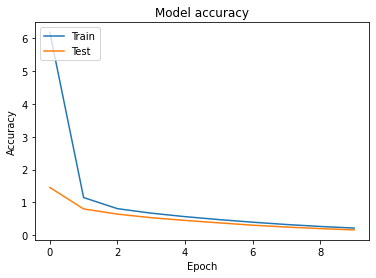

In [18]:
model.compile(loss='mean_squared_error', optimizer=Adam())
history = model.fit([train.userSeq, train.movieSeq], train.rating,
                    batch_size=32, epochs=10, verbose=1,
                    validation_data=([test.userSeq, test.movieSeq], test.rating))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Notice the validation loss is slightly lower than the training loss. If the model was overfitting, then the opposite would be true, so this is a peculiar case.

There are a few reasons this can happen:


1.   Keras artifact explained the [Keras FAQ](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss). Keras computes training loss as the average during training time, which can change quite a bit during one epoch. Validation is computed at the end of an epoch when the model loss is probably lower.
2.   The test set is not not representative of the training set. In some cases, the test set might be easier to predict than the training set. This could happen if a very small test set is used.






## Movie Similarity

The movie_embeddings vector can be used to group similar movies together. We can get these embeddings from the trained model.

In [32]:
movie_embeddings = model.get_layer('movie_embedding').get_weights()[0]

kmeans = KMeans(n_clusters=5, random_state=0).fit(movie_embeddings)

r2 = ratings.copy().drop(['userSeq', 'rating'], axis=1)
uniqueMovies = r2.drop_duplicates(subset=['movieSeq']).sort_values(by='movieSeq')
uniqueMovies['Category'] = kmeans.predict(movie_embeddings)

groups = uniqueMovies.groupby('Category')
for name, group in groups:
  print(f'Category {name}')
  m_list = '\n    '.join(group.title.values[0:10])
  print(f'    {m_list}')

Category 0
    Waiting to Exhale (1995)
    Money Train (1995)
    It Takes Two (1995)
    When Night Is Falling (1995)
    Nico Icon (1995)
    Mary Reilly (1996)
    In the Bleak Midwinter (1995)
    Catwalk (1996)
    Young Poisoner's Handbook, The (1995)
    If Lucy Fell (1996)
Category 1
    Toy Story (1995)
    Heat (1995)
    Nixon (1995)
    Sense and Sensibility (1995)
    Four Rooms (1995)
    Get Shorty (1995)
    Leaving Las Vegas (1995)
    Othello (1995)
    Persuasion (1995)
    City of Lost Children, The (Cité des enfants perdus, La) (1995)
Category 2
    Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
    Fair Game (1995)
    Amateur (1994)
    Addiction, The (1995)
    Love & Human Remains (1993)
    Mad Love (1995)
    Miami Rhapsody (1995)
    Pushing Hands (Tui shou) (1992)
    Stuart Saves His Family (1995)
    Blue Chips (1994)
Category 3
    Casino (1995)
    From Dusk Till Dawn (1996)
    Kicking and Screaming (1995)
    Beautiful Girls (1996)
    Bottle R

## Movie Outliers

The mean squared error between predictions and ground truth measure how well the model recommends movies for users or users for movies. A high mean squared error for a particular movie suggests a possible outlier.

100%|██████████| 9724/9724 [05:56<00:00, 27.28it/s]


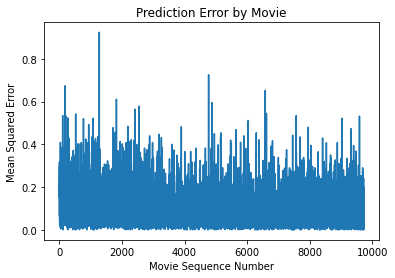

In [26]:
mse_values = []

m_ratings = ratings.copy()

for movieNumber in tqdm(range(numMovies)):
  uniqueUsers = m_ratings[m_ratings.movieSeq == movieNumber].drop_duplicates(subset=['userSeq'])
  user_vector = uniqueUsers.userSeq.unique()
  movie_vector = np.ones(len(user_vector)) * movieNumber
  predictions = model.predict([user_vector, movie_vector])
  mse = ((predictions.squeeze() - uniqueUsers.rating.values)**2).mean()
  mse_values.append(mse)

plt.plot(mse_values)
plt.title('Prediction Error by Movie')
plt.xlabel('Movie Sequence Number')
plt.ylabel('Mean Squared Error')
plt.show()

In [31]:
high_mse = np.argsort(mse_values)[::-1]

k = 5
topk = high_mse[0:k]
mse = [mse_values[i] for i in topk]
topDF = pd.DataFrame(data={'movieSeq': topk, 'mse': mse})

m_ratings = ratings.copy().drop(['userId', 'userSeq'], axis=1)
item_avg = m_ratings.groupby(['title', 'movieSeq']).mean().rename(columns={'rating':'average_rating'})
uniqueMovies = item_avg.reset_index()

uniqueMovies.merge(topDF, on='movieSeq').sort_values(by='mse', ascending=False)

,title,movieSeq,movieId,average_rating,mse
1,Bent (1997),1278,1696,3.500000,0.924421
3,Diabolique (Les diaboliques) (1955),4770,7116,3.125000,0.725329
2,Burnt by the Sun (Utomlyonnye solntsem) (1994),181,213,3.833333,0.674018
0,10th & Wolf (2006),6580,55391,4.500000,0.652658
4,"Thin Red Line, The (1998)",1825,2427,3.300000,0.610935
